In [75]:

import os
import json
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForCausalLM,
    GenerationConfig,
)
import torch
import torch.nn.functional as F
from fancy_einsum import einsum
import einops

from verl.utils.dataset.rl_dataset import RLHFDataset
from record_utils import record_activations, get_module
from parse_utils import get_target_indices
from HookedQwen import convert_to_hooked_model

In [76]:


def seed_all(seed, deterministic_algos=False):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    if deterministic_algos:
        torch.use_deterministic_algorithms()


def collate_fn(data_list: list[dict]) -> dict:
    tensors = {}
    non_tensors = {}

    for data in data_list:
        for key, val in data.items():
            if isinstance(val, torch.Tensor):
                if key not in tensors:
                    tensors[key] = []
                tensors[key].append(val)
            else:
                if key not in non_tensors:
                    non_tensors[key] = []
                non_tensors[key].append(val)

    for key, val in tensors.items():
        tensors[key] = torch.stack(val, dim=0)

    for key, val in non_tensors.items():
        non_tensors[key] = np.array(val, dtype=object)

    output = {}
    output.update(tensors)
    output.update(non_tensors)
    return output


def get_dataloader(config, tokenizer):
    import pandas as pd
    from datasets import Dataset
    from torch.utils.data import DataLoader

    data_path = config["data_path"]
    batch_size = config["batch_size"]
    max_prompt_length = config["max_prompt_length"]
    valid_size = config["valid_size"]
    data = pd.read_parquet(data_path)
    # dataset = Dataset.from_pandas(data)
    dataset = RLHFDataset(
        data_path,
        tokenizer,
        prompt_key="prompt",
        max_prompt_length=max_prompt_length,
        filter_prompts=True,
        cache_dir="~/.cache/verl/rlhf",
        chat_template_func=None,
        return_raw_chat=False,
        truncation="error",
    )

    train_dataset, valid_dataset = torch.utils.data.random_split(
        dataset, [len(dataset) - valid_size, valid_size]
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
        collate_fn=collate_fn,
    )
    return train_loader, valid_loader


def unembed(vector, lm_head, k=10):
    dots = einsum("vocab d_model, d_model -> vocab", lm_head, vector)
    top_k = dots.topk(k).indices
    return top_k


def unembed_text(vector, lm_head, tokenizer, k=10):
    top_k = unembed(vector, lm_head, k=k)
    return tokenizer.batch_decode(top_k, skip_special_tokens=True)

In [77]:

config = {
    "data_path": "data/train.parquet",
    "model_path": "checkpoints/TinyZero/v4/actor/global_step_300",
    "probe_path": "probe_checkpoints/v2/probe.pt",
    "batch_size": 4,
    "valid_size": 256,
    "max_prompt_length": 256,
    "max_response_length": 300,
    "n_layers": 36,
    "d_model": 2048,
    "seed": 42,
    "hook_config": {
        "hook_layers": list(range(24, 33)),
        "hook_target_char": " (",
        "hook_target_threshold": 0,
        "hook_scale": 20,
    },
}

In [78]:

seed_all(config["seed"])

In [79]:


model_path = config["model_path"]
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
actor_model_config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
with torch.device("cuda"):
    actor_model = AutoModelForCausalLM.from_pretrained(
        model_path, attn_implementation="eager"
    )

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [80]:

convert_to_hooked_model(actor_model)

Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward method.
Overwriting forward 

In [81]:

train_dataloader, valid_dataloader = get_dataloader(config, tokenizer)

original dataset len: 327680
filter dataset len: 327680


In [82]:

generation_config = GenerationConfig(do_sample=False)
actor_model.cuda()

# [vocab, d_model]
lm_head = actor_model.lm_head.weight

max_new_tokens = config["max_response_length"]
max_prompt_length = config["max_prompt_length"]
n_layers = config["n_layers"]
d_model = config["d_model"]
block_size = actor_model.config.max_position_embeddings
hook_config = config["hook_config"]

In [83]:

actor_model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048, padding_idx=151643)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
          (hook_attn_pattern): HookPoint()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm):

In [133]:

record_module_names = [
    "model.layers.0.self_attn.q_proj",
    "model.layers.0.self_attn.k_proj",
    "model.layers.0.self_attn.v_proj",
    "model.layers.0.self_attn.o_proj",
    "model.layers.0.self_attn.hook_attn_pattern",
]

for batch_idx, batch in enumerate(valid_dataloader):

    input_ids = batch["input_ids"].cuda()
    attention_mask = batch["attention_mask"].cuda()

    with record_activations(actor_model, record_module_names) as recording:
        output = actor_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            generation_config=generation_config,
            output_scores=False,  # this is potentially very large
            return_dict_in_generate=True,
            use_cache=True,
        )

    # len(recording["model.layers.0"]): max_response_length
    # recording["model.layers.0"][0].shape: [batch, prompt_length, d_model]
    # recording["model.layers.0"][1].shape: [batch, 1, d_model]
    # recording = {
    #    layer_name: torch.cat(acts, dim=1) for layer_name, acts in recording.items()
    # }

    # recording["model.layers.0"].shape:
    # [batch, prompt_length + max_new_tokens, d_model]
    seq = output.sequences
    response = seq[:, -max_new_tokens:]
    response_text = tokenizer.batch_decode(response, skip_special_tokens=True)

    not_batch_idxs, not_timesteps = get_target_indices(response, " (", "not", tokenizer)
    this_batch_idxs, this_timesteps = get_target_indices(
        response, " (", "this", tokenizer
    )
    print(response_text)
    if this_batch_idxs.shape[0] > 0:
        break

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
Hooked!!
zxcv
H

In [98]:

# TODO: WHy seq_len - 1?
# [batch, seq_len - 1, d_model]
# q_proj: nn.Linear(d_model, num_heads (16) * head_dim (128))
q_proj = torch.cat(recording["model.layers.0.self_attn.q_proj"], dim=1)
# [batch, seq_len - 1, d_head * num_kv_heads]
# k_proj: nn.Linear(d_model, num_key_value_heads (2) * head_dim (128))
k_proj = torch.cat(recording["model.layers.0.self_attn.k_proj"], dim=1)
# [batch, seq_len - 1, d_head * num_kv_heads]
# v_proj: nn.Linear(d_model, num_key_value_heads (2) * head_dim (128))
v_proj = torch.cat(recording["model.layers.0.self_attn.v_proj"], dim=1)
# [batch, seq_len - 1, d_model]
# o_proj: nn.Linear(num_heads (16) * head_dim (128), d_model)
o_proj = torch.cat(recording["model.layers.0.self_attn.o_proj"], dim=1)

In [99]:

batch_size = config["batch_size"]
seq_len = q_proj.shape[1]
head_dim = actor_model_config.hidden_size // actor_model_config.num_attention_heads
query_states = q_proj.view(batch_size, seq_len, -1, head_dim).transpose(1, 2)
key_states = k_proj.view(batch_size, seq_len, -1, head_dim).transpose(1, 2)
value_states = v_proj.view(batch_size, seq_len, -1, head_dim).transpose(1, 2)

print("query_states.shape:", query_states.shape)
print("key_states.shape:", key_states.shape)
print("value_states.shape:", value_states.shape)

query_states.shape: torch.Size([4, 16, 555, 128])
key_states.shape: torch.Size([4, 2, 555, 128])
value_states.shape: torch.Size([4, 2, 555, 128])


In [100]:


def pad_and_concatenate(tensor_list):
    """
    Pads and concatenates a list of tensors along the given dimension.

    Args:
        tensor_list (list of torch.Tensor): List of tensors to concatenate.

    Returns:
        torch.Tensor: Padded and concatenated tensor.
    """
    # Find the max size in the target dimension
    max_size = tensor_list[-1].shape[-1]

    # Pad each tensor to match max_size in the given dimension
    padded_tensors = []
    for tensor_idx, tensor in enumerate(tensor_list):
        if tensor_idx == 0:
            zeros = torch.zeros(
                tensor.shape[0],
                tensor.shape[1],
                tensor.shape[2],
                max_size,
                device=tensor_list[-1].device,
            )
        else:
            zeros = torch.zeros_like(tensor_list[-1])
        zeros[:, :, :, : tensor.shape[-1]] = tensor
        padded_tensors.append(zeros)

    attn_pattern = torch.cat(padded_tensors, dim=2)
    print(attn_pattern.shape)
    assert attn_pattern.shape[2] == attn_pattern.shape[3]
    return attn_pattern

In [142]:

attn_patterns = pad_and_concatenate(
    recording["model.layers.0.self_attn.hook_attn_pattern"]
)

torch.Size([4, 16, 555, 555])


In [146]:


def visualize_attention_patterns(attention_patterns):
    """
    Visualizes all attention patterns in a [num_heads, seq_len, seq_len] matrix.

    Args:
        attention_patterns (torch.Tensor): Tensor of shape [num_heads, seq_len, seq_len]
    """
    num_heads, seq_len, _ = attention_patterns.shape

    grid_size = int(num_heads**0.5)
    fig, axes = plt.subplots(
        grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4)
    )

    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)  # Upper triangular mask

    for i, ax in enumerate(axes.flat):
        attn_map = attention_patterns[i].detach().cpu().numpy()
        attn_map[mask.bool().numpy()] = float("nan")

        im = ax.imshow(attn_map, cmap="viridis", aspect="auto")

        ax.set_title(f"Head {i+1}")
        ax.set_xlabel("Key Positions")
        ax.set_ylabel("Query Positions")

        # Add color bar
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

300

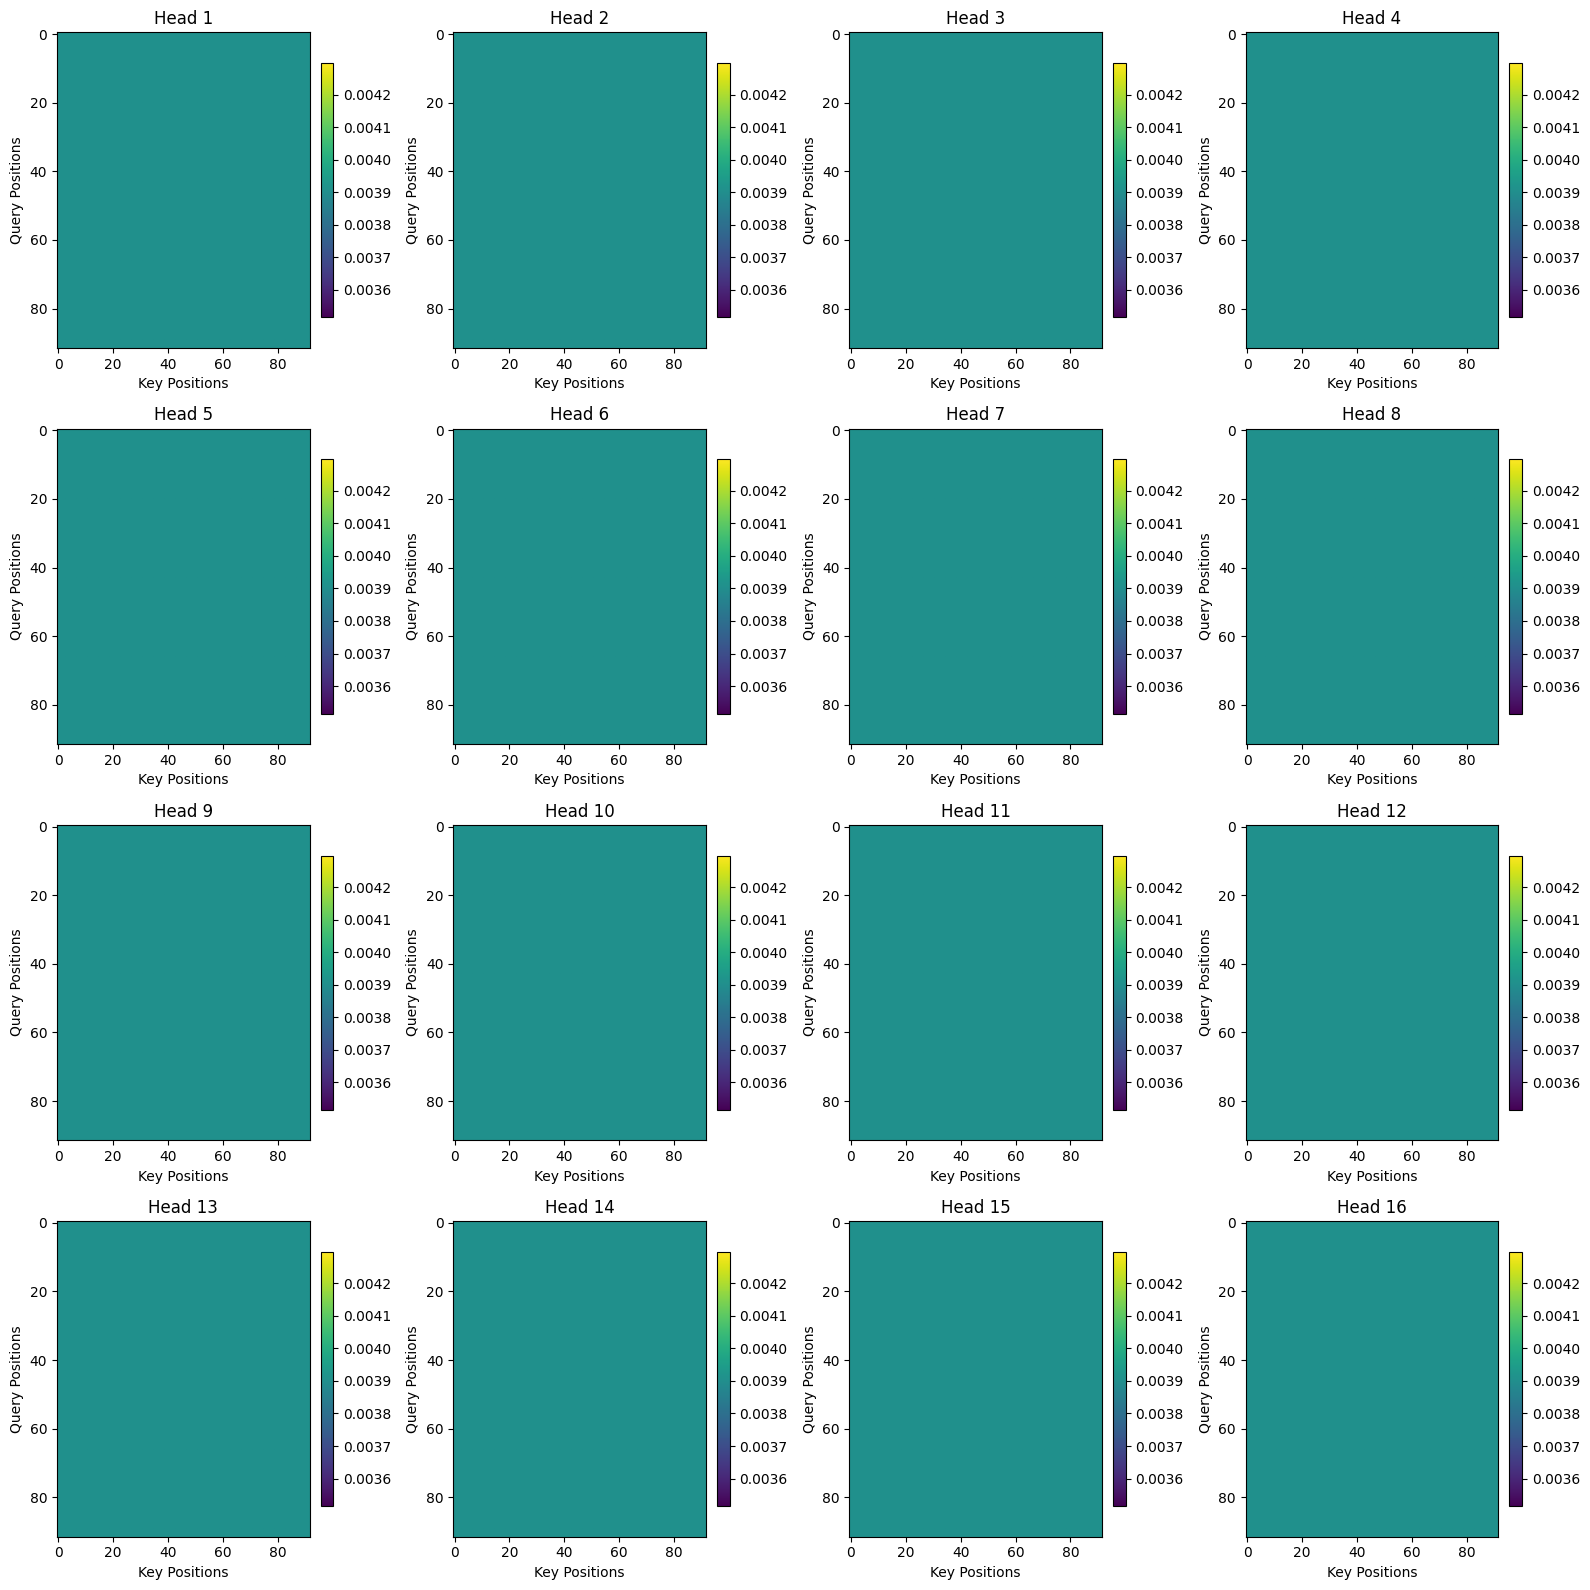

In [119]:

# Visualize the random attention patterns
for idx, b_idx in enumerate(this_batch_idxs.tolist()):
    timesteps = this_timesteps[idx]
    visualize_attention_patterns(attn_patterns[b_idx, :, :timesteps, :timesteps])